In [1]:
import os
os.chdir('../')

In [2]:
from models.GCNmodel import *
from utils import *
import torch
import torch.nn as nn

import torch.nn.functional as F
from torch_geometric.loader import DataLoader
from torch.utils.data import TensorDataset
from torchsummary import summary
import time
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import ast

In [3]:
elements = [
    'H', 'He', 'Li', 'Be', 'B', 'C', 'N', 'O', 'F', 'Ne',
    'Na', 'Mg', 'Al', 'Si', 'P', 'S', 'Cl', 'Ar', 'K', 'Ca',
    'Sc', 'Ti', 'V', 'Cr', 'Mn', 'Fe', 'Co', 'Ni', 'Cu', 'Zn',
    'Ga', 'Ge', 'As', 'Se', 'Br', 'Kr', 'Rb', 'Sr', 'Y', 'Zr',
    'Nb', 'Mo', 'Tc', 'Ru', 'Rh', 'Pd', 'Ag', 'Cd', 'In', 'Sn',
    'Sb', 'Te', 'I', 'Xe', 'Cs', 'Ba', 'La', 'Ce', 'Pr', 'Nd',
    'Pm', 'Sm', 'Eu', 'Gd', 'Tb', 'Dy', 'Ho', 'Er', 'Tm', 'Yb',
    'Lu', 'Hf', 'Ta', 'W', 'Re', 'Os', 'Ir', 'Pt', 'Au', 'Hg',
    'Tl', 'Pb', 'Bi', 'Po', 'At', 'Rn', 'Fr', 'Ra', 'Ac', 'Th',
    'Pa', 'U', 'Np', 'Pu', 'Am', 'Cm', 'Bk', 'Cf', 'Es', 'Fm',
    'Md', 'No', 'Lr', 'Rf', 'Db', 'Sg', 'Bh', 'Hs', 'Mt', 'Ds',
    'Rg', 'Cn', 'Nh', 'Fl', 'Mc', 'Lv', 'Ts', 'Og'
]

# 元素周期表的行和列
rows = [
    1, 1, 2, 2, 2, 2, 2, 2, 2, 2,
    3, 3, 3, 3, 3, 3, 3, 3, 4, 4,
    4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
    4, 4, 4, 4, 4, 4, 5, 5, 5, 5,
    5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
    5, 5, 5, 5, 6, 6, 6, 6, 6, 6,
    6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
    6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
    6, 6, 6, 6, 6, 6, 7, 7, 7, 7,
    7, 7, 7, 7, 7, 7, 7, 7, 7, 7,
    7, 7, 7, 7, 7, 7, 7, 7, 7, 7,
    7, 7, 7, 7, 7, 7, 7, 7,
]

cols = [
    1, 18, 1, 2, 13, 14, 15, 16, 17, 18,
    1, 2, 13, 14, 15, 16, 17, 18, 1, 2,
    3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
    13, 14, 15, 16, 17, 18, 1, 2, 3, 4,
    5, 6, 7, 8, 9, 10, 11, 12, 13, 14,
    15, 16, 17, 18, 1, 2, 3, 4, 5, 6,
    7, 8, 9, 10, 11, 12, 13, 14, 15, 16,
    17, 18, 3, 4, 5, 6, 7, 8, 9, 10,
    11, 12, 13, 14, 15, 16, 17, 18, 3, 4,
    5, 6, 7, 8, 9, 10, 11, 12, 13, 14,
    15, 16, 17, 18, 3, 4, 5, 6, 7, 8,
    9, 10, 11, 12, 13, 14, 15, 16,
]


# 创建 DataFrame
#df = pd.DataFrame({'Element': elements, 'Row': rows, 'Col': cols})
#
#all_positions = pd.DataFrame([(r, c) for r in range(1, 8) for c in range(1, 19)], columns=['Row', 'Col'])
#
## 将元素填充到相应的位置
#df['Element'] = pd.to_numeric(df['Element'], errors='coerce')
#ax = sns.heatmap(df.pivot_table(index='Row', columns='Col', values='Element', aggfunc='first'), annot=True, fmt='', cmap='coolwarm', cbar=False, linewidths=0.5, linecolor='black')


In [4]:
len(rows), len(cols)

(118, 118)

In [5]:
def get_attention(data,model):
    model.eval()
    with torch.no_grad():
        out,attention_list = model(data[0],data[2],(data[3]**3)/(2**0.5),return_attention=True)
        return attention_list

In [6]:
RANDOM_SEED = 119
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
batch_size = 1024
dataset=elementtables_structure_new(task='Mag')
ratio=[0.7,0.15,0.15]
train_mask, val_mask, test_mask = random_split(len(dataset),ratio)
mag_train, mag_test = dataset[train_mask], dataset[test_mask]
top=100
top_values, top_indices=torch.topk(mag_train[:][1].reshape(-1),top)
#top_indices=top_indices.to(torch.int)
model = attention_CNN().to(device)
model.load_state_dict(torch.load("result/Mag_model.pth"))

<All keys matched successfully>

In [7]:
mag_train[0].shape

torch.Size([129991, 8, 10, 10])

In [8]:
adjacent_index=[i for i in range(len(mag_train[0])) if \
                torch.max(torch.argwhere(mag_train[0][i,0,:,:].reshape(-1)!=0))-torch.min(torch.argwhere(mag_train[0][i,0,:,:].reshape(-1)!=0))<4]

In [9]:
adjacent_index[:20]

[180,
 706,
 1947,
 1951,
 2024,
 2171,
 2622,
 2957,
 4648,
 4878,
 5441,
 6693,
 6698,
 6816,
 7230,
 7333,
 7649,
 9146,
 9147,
 9411]

In [10]:
attention_list= get_attention([mag_train[i][adjacent_index] for i in range(len(mag_train))],model)

In [11]:
attention_list[0].shape

torch.Size([130, 8, 100, 100])

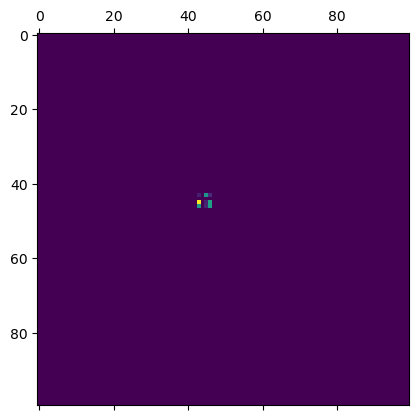

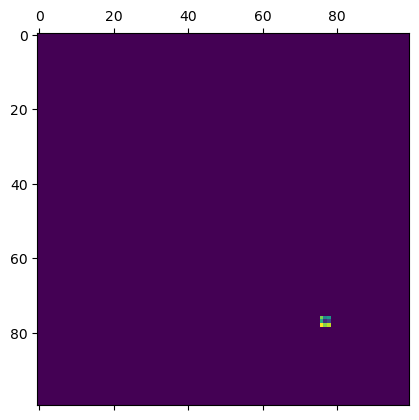

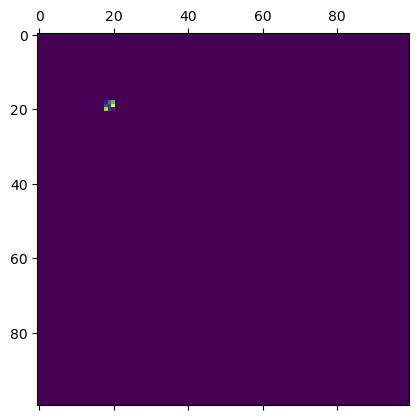

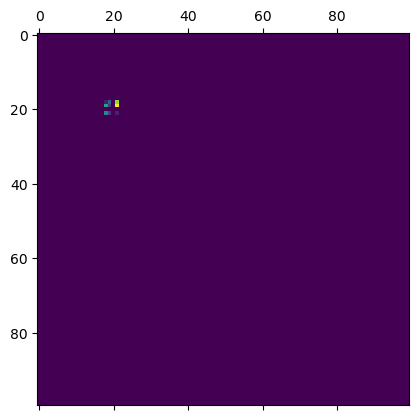

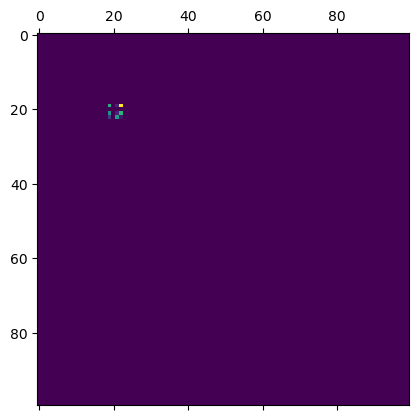

In [12]:
for i in range(5):
    plt.matshow(torch.sum(attention_list[0][i,:,:,:],dim=0).detach().cpu().numpy())

['Ru' 'Ag' 'Pd']


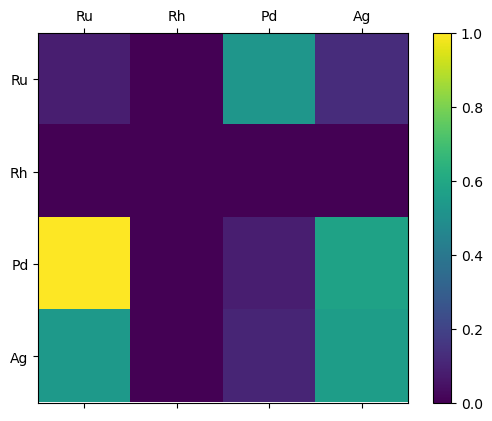

['Tc' 'Pd' 'Rh' 'Ru']


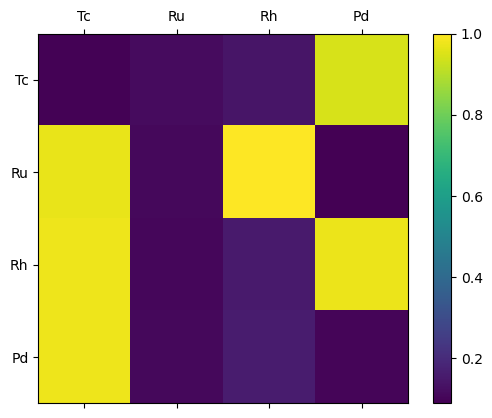

['W' 'Ir' 'Os' 'Re']


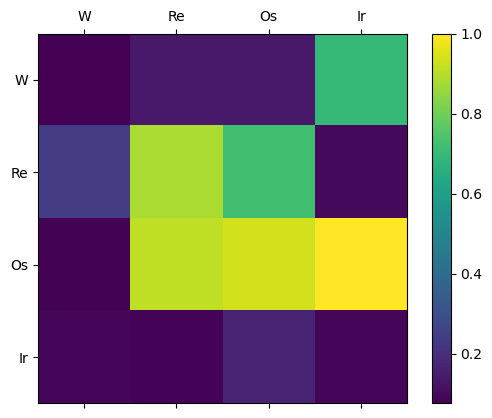

['Re' 'Ir' 'Os' 'Pt']


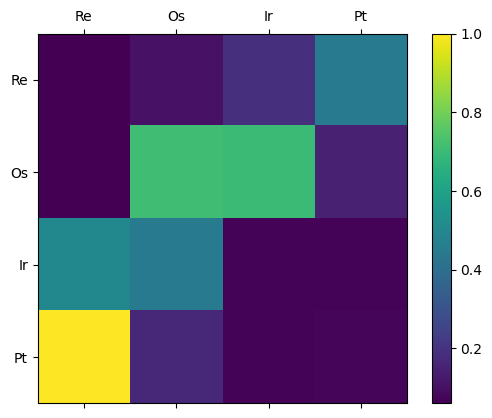

['Zn' 'Co' 'Cu' 'Ni']


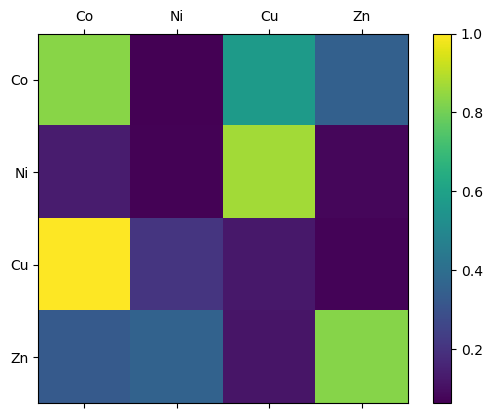

['V' 'Ca' 'Sc' 'Ti']


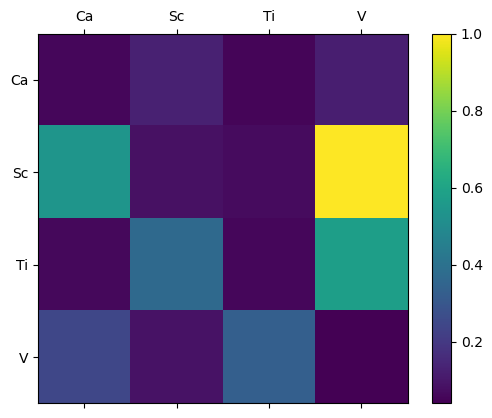

['Ti' 'Ca' 'K' 'Sc']


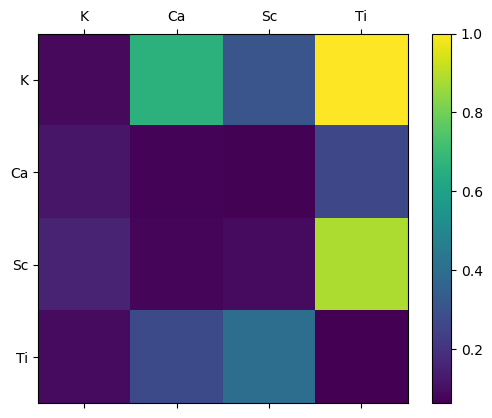

['Ru' 'Ag' 'Pd' 'Rh']


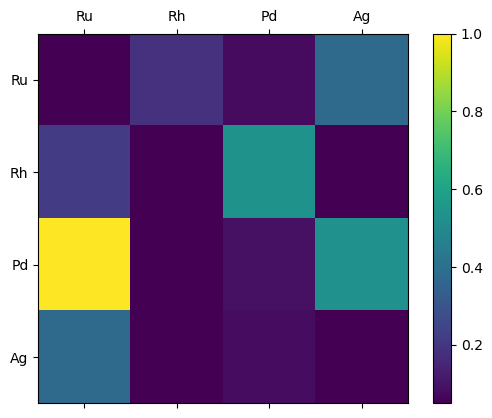

['Tc' 'Ru' 'Pd' 'Rh']


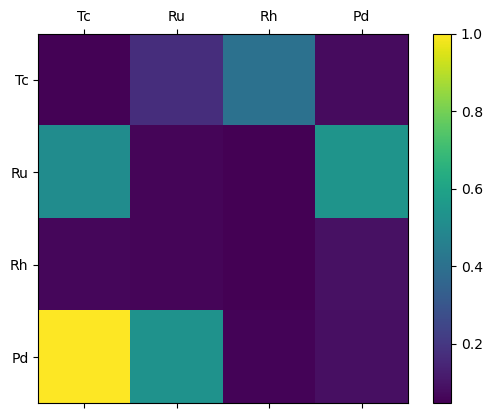

['Zr' 'Y' 'Nb' 'Sr']


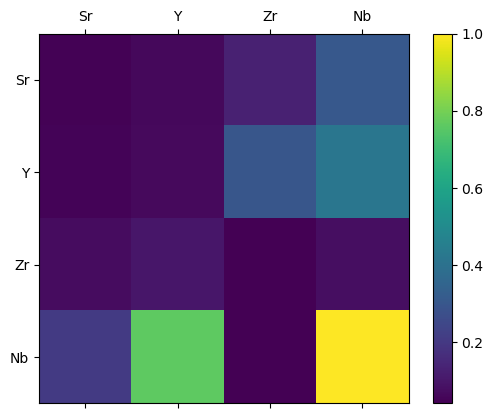

['Re' 'Pt' 'Ir' 'Os']


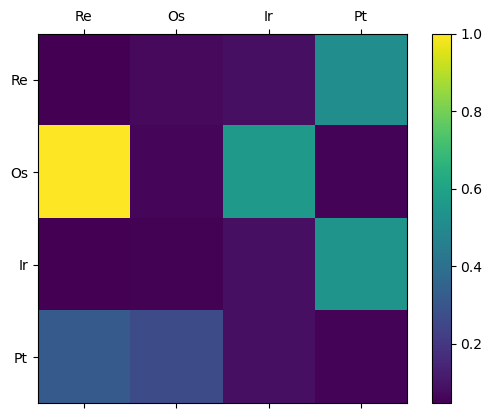

['V' 'Ti' 'Cr' 'Sc']


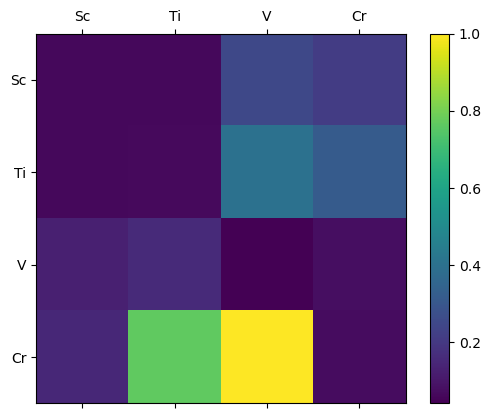

['Ni' 'Fe' 'Co' 'Cu']


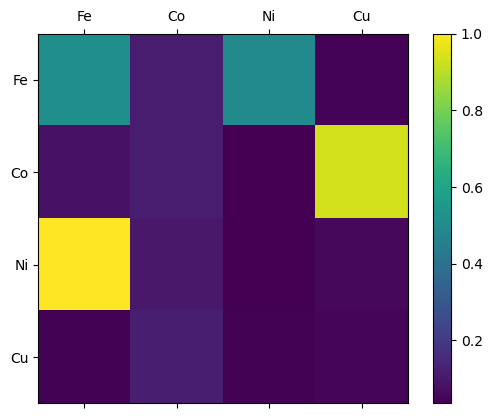

['V' 'Ti' 'Ca' 'Sc']


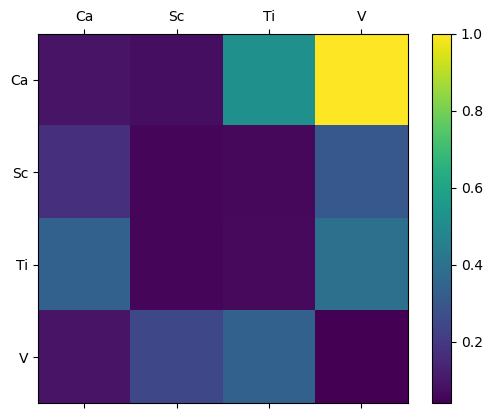

['Ru' 'Rh' 'Ag' 'Pd']


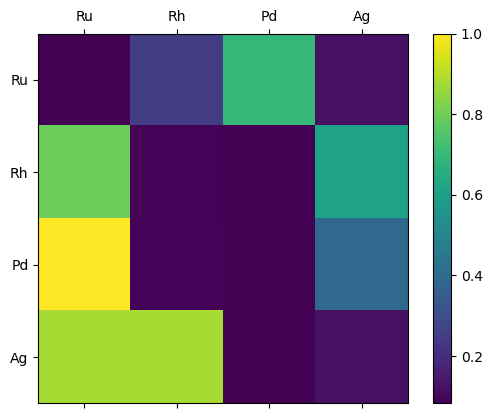

In [13]:
for i in range(15):
    fig, ax = plt.subplots()
    
    min_value=torch.min(torch.argwhere(mag_train[0][adjacent_index[-i],0,:,:].reshape(-1)!=0))
    order=torch.argwhere(mag_train[0][adjacent_index[-i],-4:,:,:].reshape(-1,100)!=0)[:,1]
    labels=ChemicalSymbols[min_value:min_value+4]
    label_order=ChemicalSymbols[order.detach().cpu().numpy()]
    print(label_order)
    sub_matrix=attention_list[0][-i,:,min_value:min_value+4,min_value:min_value+4]
    cax=ax.matshow((torch.sum(sub_matrix,dim=0)/torch.max(torch.sum(sub_matrix,dim=0))).detach().cpu().numpy())
    fig.colorbar(cax)
    ax.set_xticks(np.arange(4))
    ax.set_yticks(np.arange(4))
    ax.set_xticklabels(labels)
    ax.set_yticklabels(labels)
    plt.show()

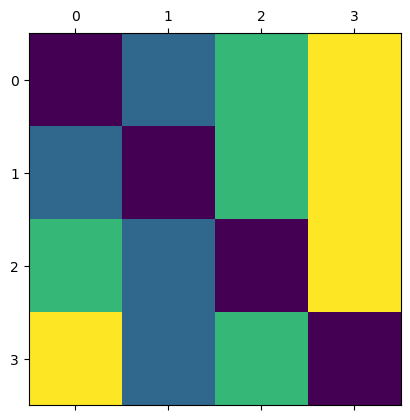

In [14]:
c_test=np.array([[0,1,2,3],[1,0,2,3],[2,1,0,3],[3,1,2,0]])
plt.matshow(c_test)

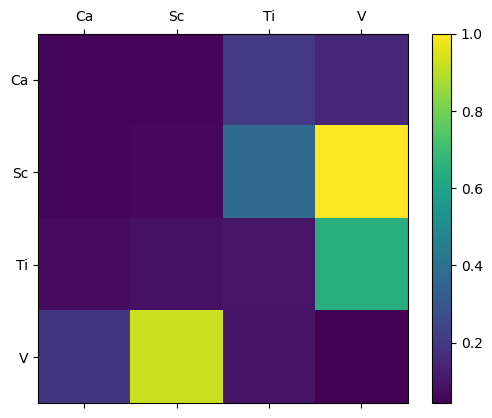

In [15]:

fig, ax = plt.subplots()

min_value=torch.min(torch.argwhere(mag_train[0][adjacent_index[-18],:,:].reshape(-1)!=0))
labels=ChemicalSymbols[min_value:min_value+4]
sub_matrix=attention_list[0][-18,:,min_value:min_value+4,min_value:min_value+4]
cax=ax.matshow((torch.sum(sub_matrix,dim=0)/torch.max(torch.sum(sub_matrix,dim=0))).detach().cpu().numpy())
fig.colorbar(cax)
ax.set_xticks(np.arange(4))
ax.set_yticks(np.arange(4))
ax.set_xticklabels(labels)
ax.set_yticklabels(labels)
plt.show()

In [16]:
[i[adjacent_index[-9]] for i in mag_train[1:]]

[tensor([0.1680], device='cuda:0'),
 tensor(216, device='cuda:0', dtype=torch.int32),
 tensor([5.4052], device='cuda:0'),
 tensor([-5.9388], device='cuda:0')]

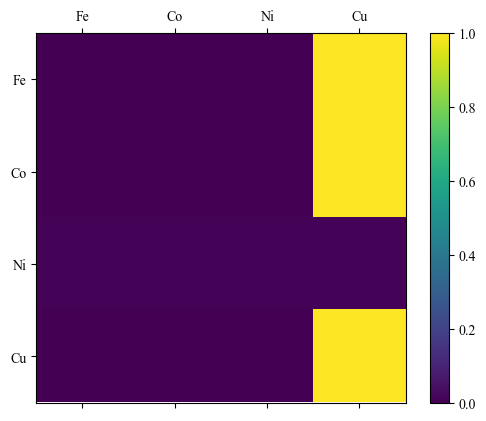

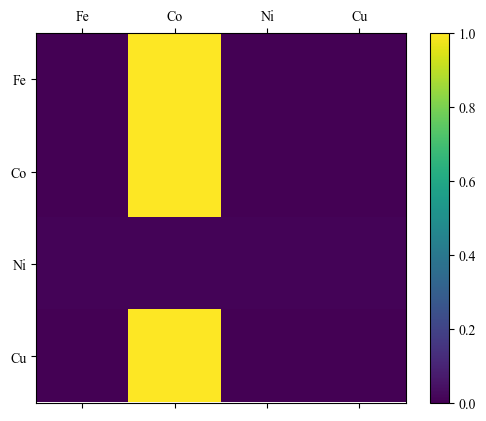

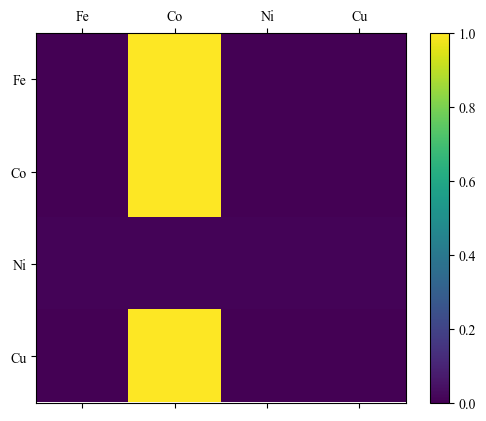

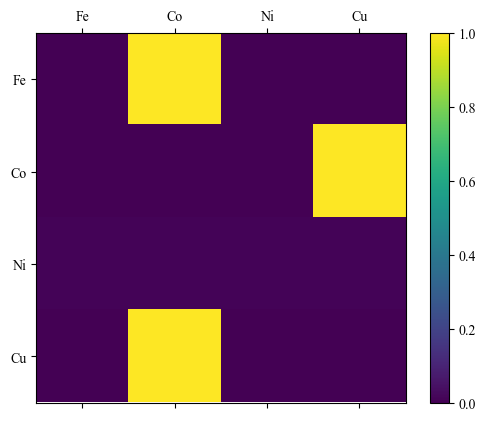

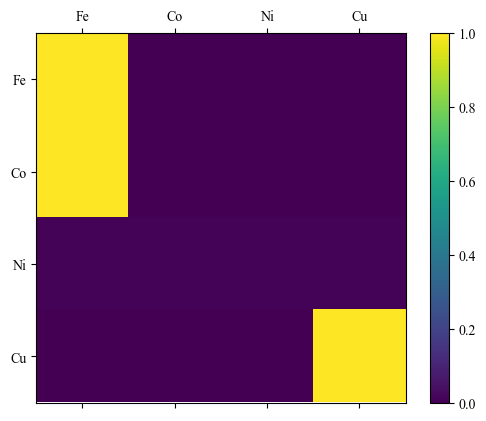

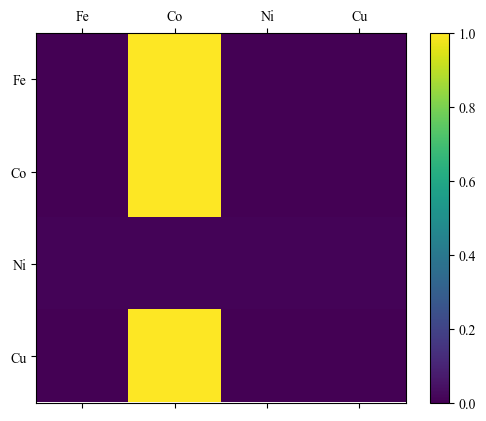

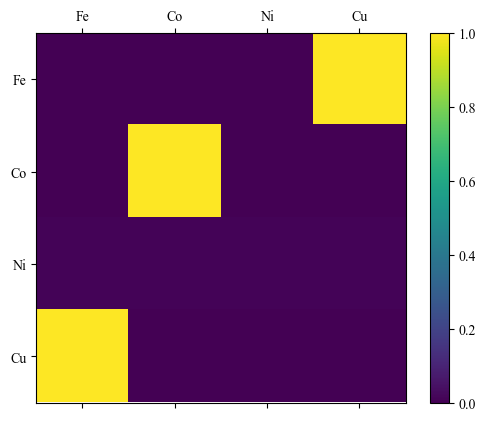

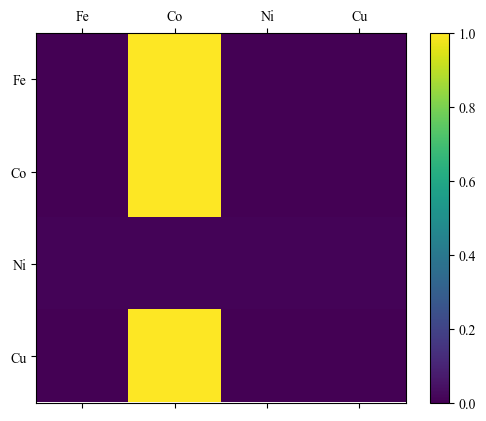

In [13]:
for i in range(8):
    fig, ax = plt.subplots()

    min_value=min(torch.argwhere(mag_train[0][adjacent_index[-27],:,:].reshape(-1)!=0))
    labels=ChemicalSymbols[min_value:min_value+4]
    sub_matrix=attention_list[0][-27,:,min_value:min_value+4,min_value:min_value+4]
    cax=ax.matshow((sub_matrix[i]/torch.max(sub_matrix[i])).detach().cpu().numpy())
    fig.colorbar(cax)
    ax.set_xticks(np.arange(4))
    ax.set_yticks(np.arange(4))
    ax.set_xticklabels(labels)
    ax.set_yticklabels(labels)
    plt.show()

In [7]:
all_dataloader = DataLoader(TensorDataset(*mag_train), batch_size=128, shuffle=False)
element_count=torch.count_nonzero(mag_train[0][:,0,:,:].reshape(-1,100),dim=0)
attention_all=torch.zeros(100,100)
for data in all_dataloader:
    attention_all+=torch.sum(get_attention(data,model)[0].detach().cpu(),dim=(0,1))


In [14]:
element_count[50:60]

tensor([ 1446,  1758,     0,     0,     0, 13236, 10055,     2,     4,     2],
       device='cuda:0')

In [15]:
attention_all[50:60,50:60]

tensor([[8.2797e+02, 1.0416e+01, 0.0000e+00, 0.0000e+00, 0.0000e+00, 4.2935e+01,
         5.2093e+01, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [1.8945e+01, 8.6257e+02, 0.0000e+00, 0.0000e+00, 0.0000e+00, 6.9977e+01,
         7.5560e+01, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [4.3616e+01, 5.0937e+01, 0.0000e+00, 0.0000e+00, 0.0000e+00, 3.1935e+03,
         4.3900e+02, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [2.3242e+01, 2.7208e+01, 0.0000e+00, 0.0000e+00, 0.0000e+00, 2.6262e+02,
         2.3353e+03, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000

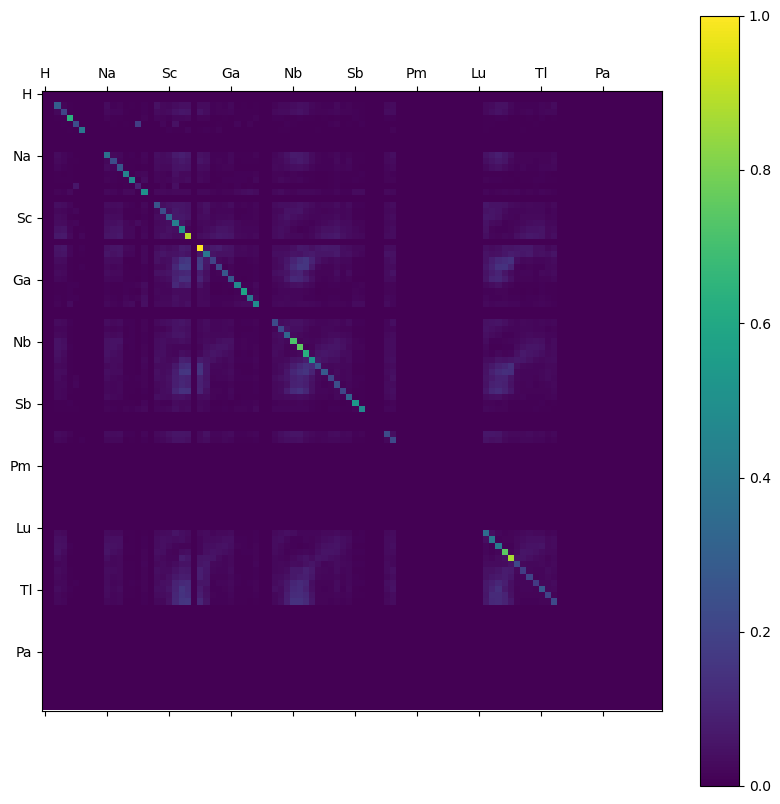

In [8]:
fig, ax = plt.subplots(figsize=(10,10))

total_matrix=attention_all.detach()
for i in range(100):
    for j in range(100):
        if element_count[i]>=50 and element_count[j]>=50:
            total_matrix[i,j]=total_matrix[i,j]/(element_count[i]*element_count[j])**0.5
        else:
            total_matrix[i,j]=0

cax=ax.matshow((total_matrix/torch.max(total_matrix)).numpy())
fig.colorbar(cax)
ax.set_xticks(np.arange(0,100,10))
ax.set_yticks(np.arange(0,100,10))
labels=[ChemicalSymbols[i] for i in range(0,100,10)]
ax.set_xticklabels(labels)
ax.set_yticklabels(labels)
plt.show()

In [52]:
total_matrix[25,25]

tensor(1.0513)

In [20]:
masked_matrix=total_matrix.clone().numpy()
np.fill_diagonal(masked_matrix,0)
masked_matrix

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

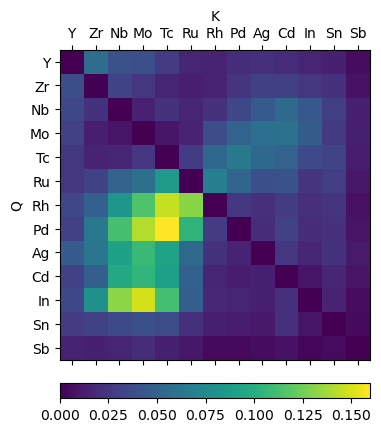

In [9]:
fig, ax = plt.subplots(figsize=(4,6))

min=38
max=51

masked_matrix=total_matrix.clone().numpy()
np.fill_diagonal(masked_matrix,0)

cax=ax.matshow(masked_matrix[min:max,min:max])
fig.colorbar(cax,location='bottom',pad=0.05)
ax.set_xticks(range(max-min))
ax.set_yticks(range(max-min))
labels=ChemicalSymbols[min:max]
ax.set_xticklabels(labels)
ax.set_yticklabels(labels)
ax.set_xlabel("K")
ax.set_ylabel("Q")
ax.xaxis.set_label_position('top')
plt.savefig("result/attention_offdiagnal.jpg",dpi=2400)
plt.show()

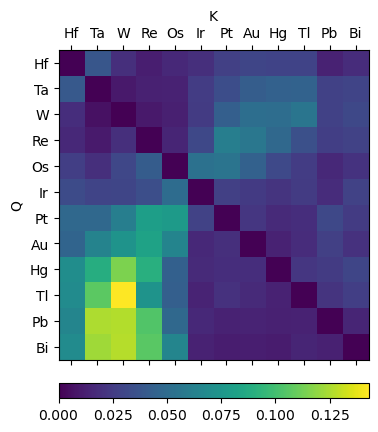

In [11]:
fig, ax = plt.subplots(figsize=(4,6))

min=71
max=83

masked_matrix=total_matrix.clone().numpy()
np.fill_diagonal(masked_matrix,0)

cax=ax.matshow(masked_matrix[min:max,min:max])
fig.colorbar(cax,location='bottom',pad=0.05)
ax.set_xticks(range(max-min))
ax.set_yticks(range(max-min))
labels=ChemicalSymbols[min:max]
ax.set_xticklabels(labels)
ax.set_yticklabels(labels)
ax.set_xlabel("K")
ax.set_ylabel("Q")
ax.xaxis.set_label_position('top')
plt.savefig("result/attention_offdiagnal71.jpg",dpi=2400)
plt.show()

In [61]:
[i[adjacent_index[-27]] for i in mag_train[1:]]

[tensor([0.9101], device='cuda:0'),
 tensor(216, device='cuda:0', dtype=torch.int32),
 tensor(-3.3770, device='cuda:0'),
 tensor(132.6882, device='cuda:0'),
 tensor(5.7251, device='cuda:0')]

In [60]:
mag_train[0][adjacent_index[-27],:,:]

tensor([[[ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
           0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
           0.0000,  0.2500,  0.2500],
         [ 0.2500,  0.2500,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
           0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
           0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
           0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
           0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
           0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
           0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
           0.0000,  0.0000,  0.0000],
 

In [34]:
torch.argwhere(attention_list[0][50,7,:,:]<0.01)

tensor([[ 0, 23],
        [ 0, 34],
        [ 0, 37],
        [ 1, 23],
        [ 1, 34],
        [ 1, 37],
        [ 2, 23],
        [ 2, 34],
        [ 2, 37],
        [ 3, 23],
        [ 3, 34],
        [ 3, 37],
        [ 4, 23],
        [ 4, 34],
        [ 4, 37],
        [ 5, 23],
        [ 5, 34],
        [ 5, 37],
        [ 6, 23],
        [ 6, 34],
        [ 6, 37],
        [ 7, 23],
        [ 7, 34],
        [ 7, 37],
        [ 8, 23],
        [ 8, 34],
        [ 8, 37],
        [ 9, 23],
        [ 9, 34],
        [ 9, 37],
        [10, 23],
        [10, 34],
        [10, 37],
        [11, 23],
        [11, 34],
        [11, 37],
        [12, 23],
        [12, 34],
        [12, 37],
        [13, 23],
        [13, 34],
        [13, 37],
        [14, 23],
        [14, 34],
        [14, 37],
        [15, 23],
        [15, 34],
        [15, 37],
        [16, 23],
        [16, 34],
        [16, 37],
        [17, 23],
        [17, 34],
        [17, 37],
        [18, 23],
        [1

In [38]:
attention_list[0][50,7,0,36]

tensor(0.0103, device='cuda:0')

In [43]:
top_values[50]

tensor(2.7477, device='cuda:0')

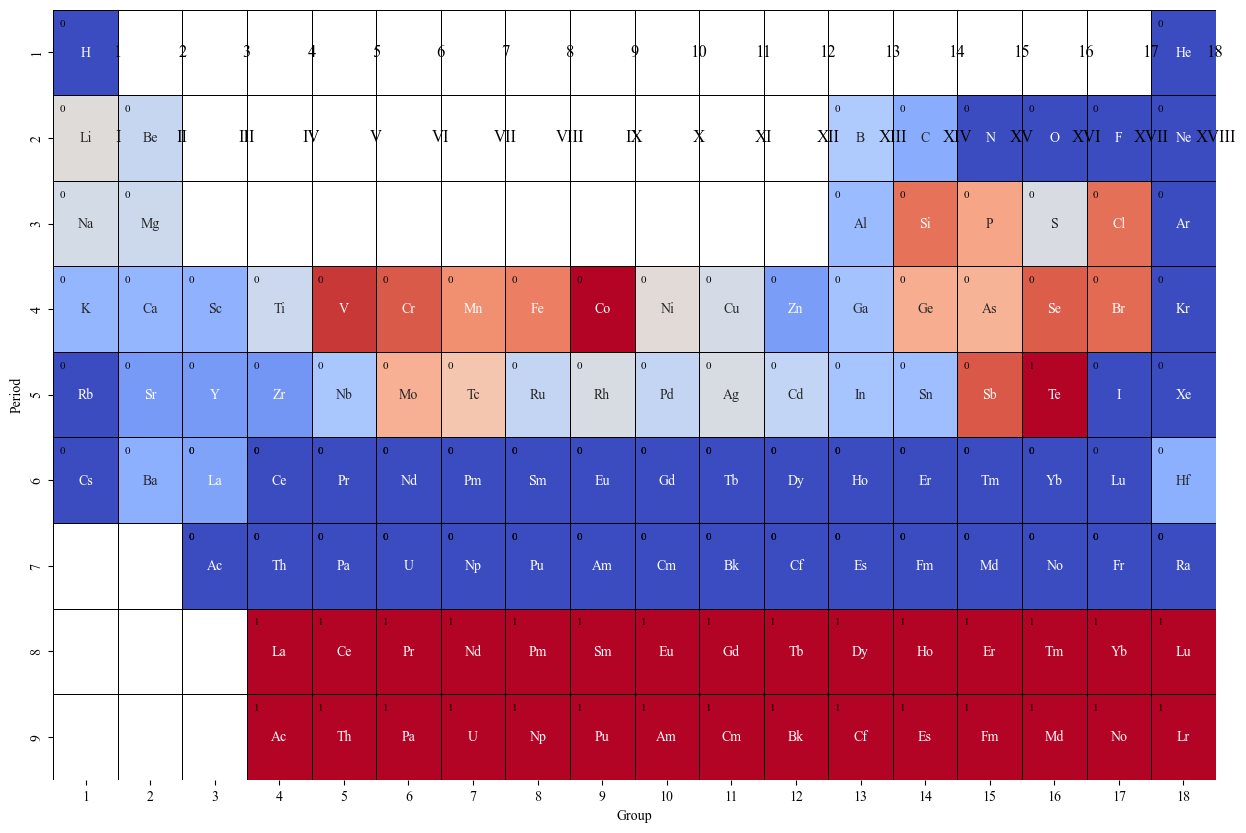

In [39]:
values=torch.zeros(118)
diagonal=torch.diag(total_matrix)
values[:len(total_matrix)]=diagonal/torch.max(diagonal)

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# 元素周期表数据
elements = [
    'H', 'He', 'Li', 'Be', 'B', 'C', 'N', 'O', 'F', 'Ne',
    'Na', 'Mg', 'Al', 'Si', 'P', 'S', 'Cl', 'Ar', 'K', 'Ca',
    'Sc', 'Ti', 'V', 'Cr', 'Mn', 'Fe', 'Co', 'Ni', 'Cu', 'Zn',
    'Ga', 'Ge', 'As', 'Se', 'Br', 'Kr', 'Rb', 'Sr', 'Y', 'Zr',
    'Nb', 'Mo', 'Tc', 'Ru', 'Rh', 'Pd', 'Ag', 'Cd', 'In', 'Sn',
    'Sb', 'Te', 'I', 'Xe', 'Cs', 'Ba', 'La', 'Ce', 'Pr', 'Nd',
    'Pm', 'Sm', 'Eu', 'Gd', 'Tb', 'Dy', 'Ho', 'Er', 'Tm', 'Yb',
    'Lu', 'Hf', 'Ta', 'W', 'Re', 'Os', 'Ir', 'Pt', 'Au', 'Hg',
    'Tl', 'Pb', 'Bi', 'Po', 'At', 'Rn', 'Fr', 'Ra', 'Ac', 'Th',
    'Pa', 'U', 'Np', 'Pu', 'Am', 'Cm', 'Bk', 'Cf', 'Es', 'Fm',
    'Md', 'No', 'Lr', 'Rf', 'Db', 'Sg', 'Bh', 'Hs', 'Mt', 'Ds',
    'Rg', 'Cn', 'Nh', 'Fl', 'Mc', 'Lv', 'Ts', 'Og'
]

# 元素周期表的行和列
rows = [
    1, 1, 2, 2, 2, 2, 2, 2, 2, 2,
    3, 3, 3, 3, 3, 3, 3, 3, 4, 4,
    4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
    4, 4, 4, 4, 4, 4, 5, 5, 5, 5,
    5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
    5, 5, 5, 5, 6, 6, 6, 6, 6, 6,
    6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
    6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
    6, 6, 6, 6, 6, 6, 7, 7, 7, 7,
    7, 7, 7, 7, 7, 7, 7, 7, 7, 7,
    7, 7, 7, 7, 7, 7, 7, 7, 7, 7,
    7, 7, 7, 7, 7, 7, 7, 7,
]

cols = [
    1, 18, 1, 2, 13, 14, 15, 16, 17, 18,
    1, 2, 13, 14, 15, 16, 17, 18, 1, 2,
    3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
    13, 14, 15, 16, 17, 18, 1, 2, 3, 4,
    5, 6, 7, 8, 9, 10, 11, 12, 13, 14,
    15, 16, 17, 18, 1, 2, 3, 4, 5, 6,
    7, 8, 9, 10, 11, 12, 13, 14, 15, 16,
    17, 18, 3, 4, 5, 6, 7, 8, 9, 10,
    11, 12, 13, 14, 15, 16, 17, 18, 3, 4,
    5, 6, 7, 8, 9, 10, 11, 12, 13, 14,
    15, 16, 17, 18, 3, 4, 5, 6, 7, 8,
    9, 10, 11, 12, 13, 14, 15, 16
]

# 示例值
#values = [1] * len(elements)

# 创建 DataFrame
df = pd.DataFrame({'Element': elements, 'Row': rows, 'Col': cols, 'Value': values})

# 添加镧系元素和锕系元素
lanthanides = ['La', 'Ce', 'Pr', 'Nd', 'Pm', 'Sm', 'Eu', 'Gd', 'Tb', 'Dy', 'Ho', 'Er', 'Tm', 'Yb', 'Lu']
actinides = ['Ac', 'Th', 'Pa', 'U', 'Np', 'Pu', 'Am', 'Cm', 'Bk', 'Cf', 'Es', 'Fm', 'Md', 'No', 'Lr']

lanthanide_rows = [8] * len(lanthanides)
lanthanide_cols = list(range(4, 4 + len(lanthanides)))

actinide_rows = [9] * len(actinides)
actinide_cols = list(range(4, 4 + len(actinides)))

lanthanide_values = [1] * len(lanthanides)
actinide_values = [1] * len(actinides)

lanthanide_df = pd.DataFrame({'Element': lanthanides, 'Row': lanthanide_rows, 'Col': lanthanide_cols, 'Value': lanthanide_values})
actinide_df = pd.DataFrame({'Element': actinides, 'Row': actinide_rows, 'Col': actinide_cols, 'Value': actinide_values})

df = pd.concat([df, lanthanide_df, actinide_df], ignore_index=True)

# 创建一个包含所有可能位置的 DataFrame
all_positions = pd.DataFrame([(r, c) for r in range(1, 10) for c in range(1, 19)], columns=['Row', 'Col'])

# 将元素填充到相应的位置
df = pd.merge(all_positions, df, how='left', on=['Row', 'Col'])

latin_numbers = list(range(1, 19))
roman_numbers = ['I', 'II', 'III', 'IV', 'V', 'VI', 'VII', 'VIII', 'IX', 'X', 'XI', 'XII', 'XIII', 'XIV', 'XV', 'XVI', 'XVII', 'XVIII']

plt.figure(figsize=(15, 10))

for i, (latin, roman) in enumerate(zip(latin_numbers, roman_numbers)):
    plt.text(i + 1, 0.5, latin, ha='center', va='center', fontsize=12)
    plt.text(i + 1, 1.5, roman, ha='center', va='center', fontsize=12)

# 绘制元素周期表
heatmap_data = df.pivot_table(index='Row', columns='Col', values='Value', aggfunc='first')
ax = sns.heatmap(heatmap_data, annot=df.pivot_table(index='Row', columns='Col', values='Element', aggfunc='first'), fmt='', cmap='coolwarm', cbar=False, linewidths=0.5, linecolor='black')

for i in range(len(df)):
    if not pd.isnull(df.loc[i, 'Element']):
        ax.text(df.loc[i, 'Col'] - 1 + 0.1, df.loc[i, 'Row'] - 1 + 0.1, int(df.loc[i, 'Value']), ha='left', va='top', fontsize=8, color='black')


# 设置轴标签
ax.set_xlabel('Group')
ax.set_ylabel('Period')

# 显示图表
plt.show()

C:\Users\yhluPC\AppData\Local\Temp\ipykernel_44424\1193133487.py:78: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation.
  df = pd.merge(all_positions, df, how='left', on=['Row', 'Col'])


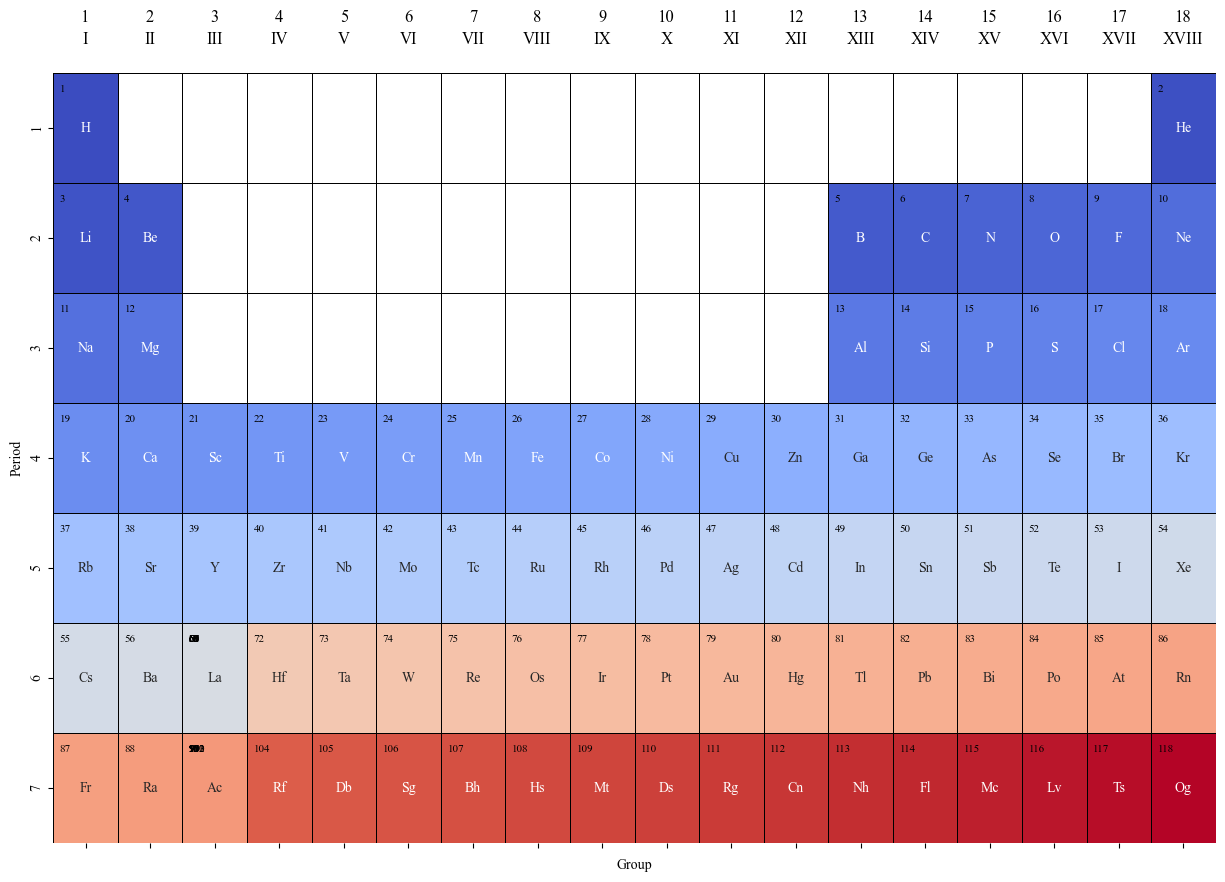

In [53]:
values=torch.zeros(118)
diagonal=torch.diag(total_matrix)
values[:len(total_matrix)]=diagonal/torch.max(diagonal)

# 元素周期表数据
elements = [
    'H', 'He', 'Li', 'Be', 'B', 'C', 'N', 'O', 'F', 'Ne',
    'Na', 'Mg', 'Al', 'Si', 'P', 'S', 'Cl', 'Ar', 'K', 'Ca',
    'Sc', 'Ti', 'V', 'Cr', 'Mn', 'Fe', 'Co', 'Ni', 'Cu', 'Zn',
    'Ga', 'Ge', 'As', 'Se', 'Br', 'Kr', 'Rb', 'Sr', 'Y', 'Zr',
    'Nb', 'Mo', 'Tc', 'Ru', 'Rh', 'Pd', 'Ag', 'Cd', 'In', 'Sn',
    'Sb', 'Te', 'I', 'Xe', 'Cs', 'Ba', 'La', 'Ce', 'Pr', 'Nd',
    'Pm', 'Sm', 'Eu', 'Gd', 'Tb', 'Dy', 'Ho', 'Er', 'Tm', 'Yb',
    'Lu', 'Hf', 'Ta', 'W', 'Re', 'Os', 'Ir', 'Pt', 'Au', 'Hg',
    'Tl', 'Pb', 'Bi', 'Po', 'At', 'Rn', 'Fr', 'Ra', 'Ac', 'Th',
    'Pa', 'U', 'Np', 'Pu', 'Am', 'Cm', 'Bk', 'Cf', 'Es', 'Fm',
    'Md', 'No', 'Lr', 'Rf', 'Db', 'Sg', 'Bh', 'Hs', 'Mt', 'Ds',
    'Rg', 'Cn', 'Nh', 'Fl', 'Mc', 'Lv', 'Ts', 'Og'
]

# 元素周期表的行和列
rows = [
    1, 1, 2, 2, 2, 2, 2, 2, 2, 2,
    3, 3, 3, 3, 3, 3, 3, 3, 4, 4,
    4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
    4, 4, 4, 4, 4, 4, 5, 5, 5, 5,
    5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
    5, 5, 5, 5, 6, 6, 6, 6, 6, 6,
    6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
    6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
    6, 6, 6, 6, 6, 6, 7, 7, 7, 7,
    7, 7, 7, 7, 7, 7, 7, 7, 7, 7,
    7, 7, 7, 7, 7, 7, 7, 7, 7, 7,
    7, 7, 7, 7, 7, 7, 7, 7,
]

cols = [
    1, 18, 1, 2, 13, 14, 15, 16, 17, 18,
    1, 2, 13, 14, 15, 16, 17, 18, 1, 2,
    3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
    13, 14, 15, 16, 17, 18, 1, 2, 3, 4,
    5, 6, 7, 8, 9, 10, 11, 12, 13, 14,
    15, 16, 17, 18, 1, 2, 3,3,3,3,3,3,3,3,3,3,3,3,3,3,3, 4, 5, 6,
    7, 8, 9, 10, 11, 12, 13, 14, 15, 16,
    17, 18, 1 ,2, 3,3,3,3,3,3,3,3,3,3,3,3,3,3,3, 4,
    5, 6, 7, 8, 9, 10, 11, 12, 13, 14,
    15, 16, 17, 18, 
]

# 示例值
values = list(range(1, len(elements) + 1))

# 创建 DataFrame
df = pd.DataFrame({'Element': elements, 'Row': rows, 'Col': cols, 'Value': values})

# 添加镧系元素和锕系元素
lanthanides = ['La', 'Ce', 'Pr', 'Nd', 'Pm', 'Sm', 'Eu', 'Gd', 'Tb', 'Dy', 'Ho', 'Er', 'Tm', 'Yb', 'Lu']
actinides = ['Ac', 'Th', 'Pa', 'U', 'Np', 'Pu', 'Am', 'Cm', 'Bk', 'Cf', 'Es', 'Fm', 'Md', 'No', 'Lr']

lanthanide_rows = [8.5] * len(lanthanides)
lanthanide_cols = list(range(4, 4 + len(lanthanides)))

actinide_rows = [9.5] * len(actinides)
actinide_cols = list(range(4, 4 + len(actinides)))

lanthanide_values = list(range(len(elements) + 1, len(elements) + 1 + len(lanthanides)))
actinide_values = list(range(len(elements) + 1 + len(lanthanides), len(elements) + 1 + len(lanthanides) + len(actinides)))

lanthanide_df = pd.DataFrame({'Element': lanthanides, 'Row': lanthanide_rows, 'Col': lanthanide_cols, 'Value': lanthanide_values})
actinide_df = pd.DataFrame({'Element': actinides, 'Row': actinide_rows, 'Col': actinide_cols, 'Value': actinide_values})

df = pd.concat([df, lanthanide_df, actinide_df], ignore_index=True)

# 创建一个包含所有可能位置的 DataFrame
all_positions = pd.DataFrame([(r, c) for r in range(1, 10) for c in range(1, 19)], columns=['Row', 'Col'])

# 将元素填充到相应的位置
df = pd.merge(all_positions, df, how='left', on=['Row', 'Col'])

# 绘制元素周期表
plt.figure(figsize=(15, 10))

# 绘制拉丁数字和罗马数字
latin_numbers = list(range(1, 19))
roman_numbers = ['I', 'II', 'III', 'IV', 'V', 'VI', 'VII', 'VIII', 'IX', 'X', 'XI', 'XII', 'XIII', 'XIV', 'XV', 'XVI', 'XVII', 'XVIII']

for i, (latin, roman) in enumerate(zip(latin_numbers, roman_numbers)):
    plt.text(i + 0.5, -0.5, latin, ha='center', va='center', fontsize=12)
    plt.text(i + 0.5, -0.3, roman, ha='center', va='center', fontsize=12)

# 绘制热图
heatmap_data = df.pivot_table(index='Row', columns='Col', values='Value', aggfunc='first')
ax = sns.heatmap(heatmap_data, annot=df.pivot_table(index='Row', columns='Col', values='Element', aggfunc='first'), fmt='', cmap='coolwarm', cbar=False, linewidths=0.5, linecolor='black', mask=heatmap_data.isnull())

# 在每个单元格的左上角显示元素编号
for i in range(len(df)):
    if not pd.isnull(df.loc[i, 'Element']):
        ax.text(df.loc[i, 'Col'] - 1 + 0.1, df.loc[i, 'Row'] - 1 + 0.1, int(df.loc[i, 'Value']), ha='left', va='top', fontsize=8, color='black')

# 设置轴标签
ax.set_xlabel('Group')
ax.set_ylabel('Period')

# 隐藏行号
ax.set_xticklabels([])

# 显示图表
plt.show()

C:\Users\yhluPC\AppData\Local\Temp\ipykernel_44424\2490250865.py:79: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation.
  df = pd.merge(all_positions, df, how='left', on=['Row', 'Col'])


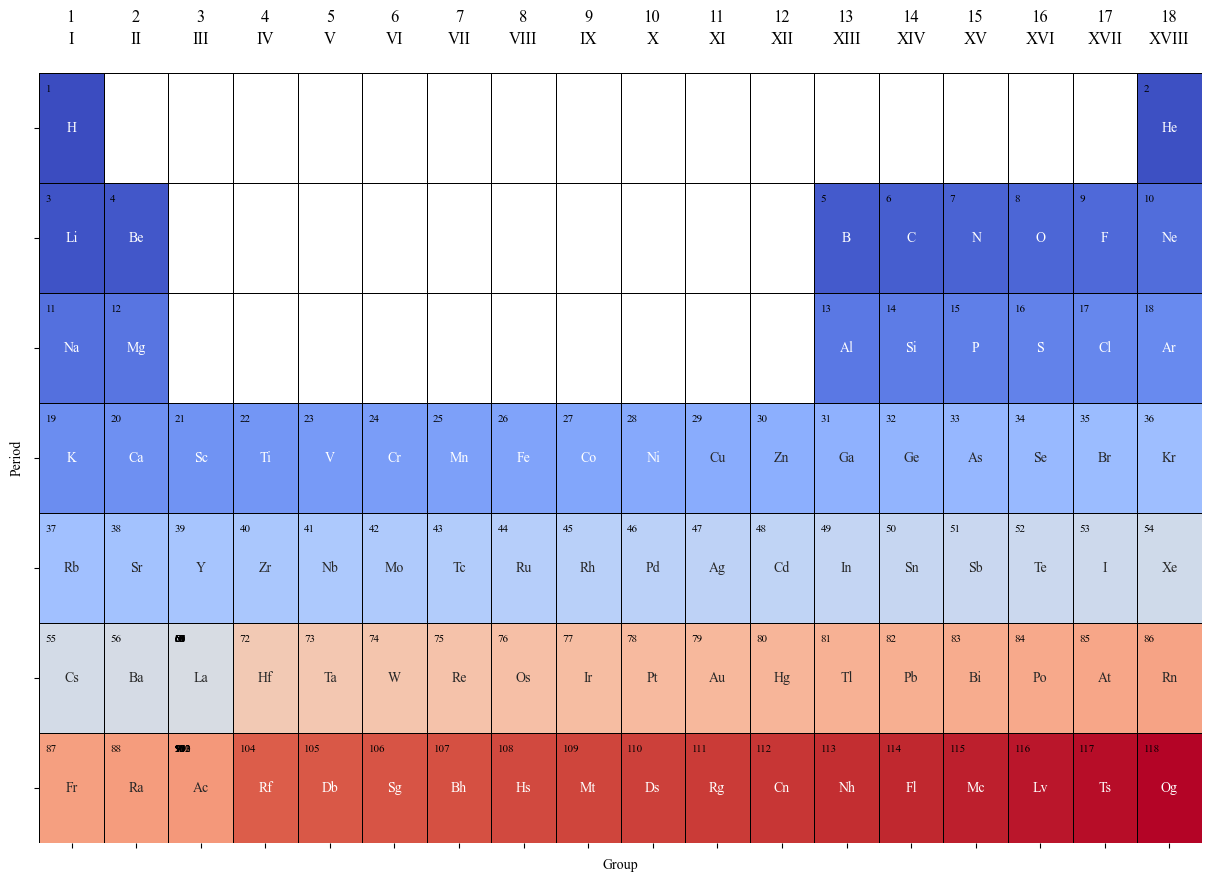

In [100]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# 元素周期表数据
elements = [
    'H', 'He', 'Li', 'Be', 'B', 'C', 'N', 'O', 'F', 'Ne',
    'Na', 'Mg', 'Al', 'Si', 'P', 'S', 'Cl', 'Ar', 'K', 'Ca',
    'Sc', 'Ti', 'V', 'Cr', 'Mn', 'Fe', 'Co', 'Ni', 'Cu', 'Zn',
    'Ga', 'Ge', 'As', 'Se', 'Br', 'Kr', 'Rb', 'Sr', 'Y', 'Zr',
    'Nb', 'Mo', 'Tc', 'Ru', 'Rh', 'Pd', 'Ag', 'Cd', 'In', 'Sn',
    'Sb', 'Te', 'I', 'Xe', 'Cs', 'Ba', 'La', 'Ce', 'Pr', 'Nd',
    'Pm', 'Sm', 'Eu', 'Gd', 'Tb', 'Dy', 'Ho', 'Er', 'Tm', 'Yb',
    'Lu', 'Hf', 'Ta', 'W', 'Re', 'Os', 'Ir', 'Pt', 'Au', 'Hg',
    'Tl', 'Pb', 'Bi', 'Po', 'At', 'Rn', 'Fr', 'Ra', 'Ac', 'Th',
    'Pa', 'U', 'Np', 'Pu', 'Am', 'Cm', 'Bk', 'Cf', 'Es', 'Fm',
    'Md', 'No', 'Lr', 'Rf', 'Db', 'Sg', 'Bh', 'Hs', 'Mt', 'Ds',
    'Rg', 'Cn', 'Nh', 'Fl', 'Mc', 'Lv', 'Ts', 'Og'
]

# 元素周期表的行和列
rows = [
    1, 1, 2, 2, 2, 2, 2, 2, 2, 2,
    3, 3, 3, 3, 3, 3, 3, 3, 4, 4,
    4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
    4, 4, 4, 4, 4, 4, 5, 5, 5, 5,
    5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
    5, 5, 5, 5, 6, 6, 6, 6, 6, 6,
    6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
    6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
    6, 6, 6, 6, 6, 6, 7, 7, 7, 7,
    7, 7, 7, 7, 7, 7, 7, 7, 7, 7,
    7, 7, 7, 7, 7, 7, 7, 7, 7, 7,
    7, 7, 7, 7, 7, 7, 7, 7,
]

cols = [
    1, 18, 1, 2, 13, 14, 15, 16, 17, 18,
    1, 2, 13, 14, 15, 16, 17, 18, 1, 2,
    3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
    13, 14, 15, 16, 17, 18, 1, 2, 3, 4,
    5, 6, 7, 8, 9, 10, 11, 12, 13, 14,
    15, 16, 17, 18, 1, 2, 3,3,3,3,3,3,3,3,3,3,3,3,3,3,3, 4, 5, 6,
    7, 8, 9, 10, 11, 12, 13, 14, 15, 16,
    17, 18, 1 ,2, 3,3,3,3,3,3,3,3,3,3,3,3,3,3,3, 4,
    5, 6, 7, 8, 9, 10, 11, 12, 13, 14,
    15, 16, 17, 18, 
]

# 示例值
values = list(range(1, len(elements) + 1))

# 创建 DataFrame
df = pd.DataFrame({'Element': elements, 'Row': rows, 'Col': cols, 'Value': values})

# 添加镧系元素和锕系元素
lanthanides = ['La', 'Ce', 'Pr', 'Nd', 'Pm', 'Sm', 'Eu', 'Gd', 'Tb', 'Dy', 'Ho', 'Er', 'Tm', 'Yb', 'Lu']
actinides = ['Ac', 'Th', 'Pa', 'U', 'Np', 'Pu', 'Am', 'Cm', 'Bk', 'Cf', 'Es', 'Fm', 'Md', 'No', 'Lr']

lanthanide_rows = [8.5] * len(lanthanides)
lanthanide_cols = list(range(4, 4 + len(lanthanides)))

actinide_rows = [9.5] * len(actinides)
actinide_cols = list(range(4, 4 + len(actinides)))

lanthanide_values = list(range(len(elements) + 1, len(elements) + 1 + len(lanthanides)))
actinide_values = list(range(len(elements) + 1 + len(lanthanides), len(elements) + 1 + len(lanthanides) + len(actinides)))

lanthanide_df = pd.DataFrame({'Element': lanthanides, 'Row': lanthanide_rows, 'Col': lanthanide_cols, 'Value': lanthanide_values})
actinide_df = pd.DataFrame({'Element': actinides, 'Row': actinide_rows, 'Col': actinide_cols, 'Value': actinide_values})

df = pd.concat([df, lanthanide_df, actinide_df], ignore_index=True)

# 创建一个包含所有可能位置的 DataFrame
all_positions = pd.DataFrame([(r, c) for r in np.arange(1, 11) for c in range(1, 19)], columns=['Row', 'Col'])

# 将元素填充到相应的位置
df = pd.merge(all_positions, df, how='left', on=['Row', 'Col'])

# 绘制元素周期表
plt.figure(figsize=(15, 10))

# 绘制拉丁数字和罗马数字
latin_numbers = list(range(1, 19))
roman_numbers = ['I', 'II', 'III', 'IV', 'V', 'VI', 'VII', 'VIII', 'IX', 'X', 'XI', 'XII', 'XIII', 'XIV', 'XV', 'XVI', 'XVII', 'XVIII']

for i, (latin, roman) in enumerate(zip(latin_numbers, roman_numbers)):
    plt.text(i + 0.5, -0.5, latin, ha='center', va='center', fontsize=12)
    plt.text(i + 0.5, -0.3, roman, ha='center', va='center', fontsize=12)

# 绘制热图
heatmap_data = df.pivot_table(index='Row', columns='Col', values='Value', aggfunc='first')
ax = sns.heatmap(heatmap_data, annot=df.pivot_table(index='Row', columns='Col', values='Element', aggfunc='first'), fmt='', cmap='coolwarm', cbar=False, linewidths=0.5, linecolor='black', mask=heatmap_data.isnull())

# 在每个单元格的左上角显示元素编号
for i in range(len(df)):
    if not pd.isnull(df.loc[i, 'Element']):
        ax.text(df.loc[i, 'Col'] - 1 + 0.1, df.loc[i, 'Row'] - 1 + 0.1, int(df.loc[i, 'Value']), ha='left', va='top', fontsize=8, color='black')

# 设置轴标签
ax.set_xlabel('Group')
ax.set_ylabel('Period')

# 隐藏行号
ax.set_xticklabels([])

# 隐藏列号
ax.set_yticklabels([])

# 显示图表
plt.show()

In [109]:
elements

['H',
 'He',
 'Li',
 'Be',
 'B',
 'C',
 'N',
 'O',
 'F',
 'Ne',
 'Na',
 'Mg',
 'Al',
 'Si',
 'P',
 'S',
 'Cl',
 'Ar',
 'K',
 'Ca',
 'Sc',
 'Ti',
 'V',
 'Cr',
 'Mn',
 'Fe',
 'Co',
 'Ni',
 'Cu',
 'Zn',
 'Ga',
 'Ge',
 'As',
 'Se',
 'Br',
 'Kr',
 'Rb',
 'Sr',
 'Y',
 'Zr',
 'Nb',
 'Mo',
 'Tc',
 'Ru',
 'Rh',
 'Pd',
 'Ag',
 'Cd',
 'In',
 'Sn',
 'Sb',
 'Te',
 'I',
 'Xe',
 'Cs',
 'Ba',
 'La',
 'Ce',
 'Pr',
 'Nd',
 'Pm',
 'Sm',
 'Eu',
 'Gd',
 'Tb',
 'Dy',
 'Ho',
 'Er',
 'Tm',
 'Yb',
 'Lu',
 'Hf',
 'Ta',
 'W',
 'Re',
 'Os',
 'Ir',
 'Pt',
 'Au',
 'Hg',
 'Tl',
 'Pb',
 'Bi',
 'Po',
 'At',
 'Rn',
 'Fr',
 'Ra',
 'Ac',
 'Th',
 'Pa',
 'U',
 'Np',
 'Pu',
 'Am',
 'Cm',
 'Bk',
 'Cf',
 'Es',
 'Fm',
 'Md',
 'No',
 'Lr',
 'Rf',
 'Db',
 'Sg',
 'Bh',
 'Hs',
 'Mt',
 'Ds',
 'Rg',
 'Cn',
 'Nh',
 'Fl',
 'Mc',
 'Lv',
 'Ts',
 'Og']

In [75]:
file_list=os.listdir('datasets')

count_mag=np.zeros((118,2))
average_mag=np.zeros((118,2))
for f in file_list:
    df=pd.read_csv('datasets/'+f,sep='\t',header=0)
    
    for i in range(len(df)):
        if df.loc[i,'spin_cell']<0.01:
            continue
        namelist,numlist=readComponent([df.loc[i,'compound']])
        numlist=np.array(numlist[0],dtype=np.int32)
        namelist=namelist[0]
        for j in range(len(namelist)):
            average_mag[np.argwhere(ChemicalSymbols==namelist[j])[0][0],0]+=1
            average_mag[np.argwhere(ChemicalSymbols==namelist[j])[0][0],1]+=abs(df.loc[i,'spin_cell'])/sum(numlist)
        if df.loc[i,'spinD']=='[]':
            continue
        spinD=ast.literal_eval(df.loc[i,'spinD'])
        if len(spinD)>4:
            continue
        
        index=0
        if sum(numlist)!=len(spinD):
            continue
        for j in range(len(namelist)):
            for k in range(numlist[j]):
                count_mag[np.argwhere(ChemicalSymbols==namelist[j])[0][0],0]+=1
                count_mag[np.argwhere(ChemicalSymbols==namelist[j])[0][0],1]+=abs(spinD[index])
                index+=1

C:\Users\yhluPC\AppData\Local\Temp\ipykernel_8132\3300674858.py:6: DtypeWarning: Columns (6,7,8) have mixed types. Specify dtype option on import or set low_memory=False.
  df=pd.read_csv('datasets/'+f,sep='\t',header=0)
C:\Users\yhluPC\AppData\Local\Temp\ipykernel_8132\3300674858.py:6: DtypeWarning: Columns (11) have mixed types. Specify dtype option on import or set low_memory=False.
  df=pd.read_csv('datasets/'+f,sep='\t',header=0)


In [76]:
for i in range(118):
    if count_mag[i,0]>0:
        count_mag[i,1]=count_mag[i,1]/count_mag[i,0]
    if average_mag[i,0]>0:
        average_mag[i,1]=average_mag[i,1]/average_mag[i,0]

In [77]:
threshold=100
min_value=np.min(average_mag[average_mag[:,1]>0.03,1])
average_mag[:,1]=average_mag[:,1]-min_value
average_mag[24,0]=0
for i in range(118):
    if average_mag[i,0]<threshold:
        count_mag[i,1]=0
        average_mag[i,1]=0

In [78]:
from ptplotter import *

In [79]:
values=torch.zeros(118)
diagonal=torch.diag(total_matrix)
values[:len(total_matrix)]=diagonal/torch.max(diagonal)

In [80]:
elements

['H',
 'He',
 'Li',
 'Be',
 'B',
 'C',
 'N',
 'O',
 'F',
 'Ne',
 'Na',
 'Mg',
 'Al',
 'Si',
 'P',
 'S',
 'Cl',
 'Ar',
 'K',
 'Ca',
 'Sc',
 'Ti',
 'V',
 'Cr',
 'Mn',
 'Fe',
 'Co',
 'Ni',
 'Cu',
 'Zn',
 'Ga',
 'Ge',
 'As',
 'Se',
 'Br',
 'Kr',
 'Rb',
 'Sr',
 'Y',
 'Zr',
 'Nb',
 'Mo',
 'Tc',
 'Ru',
 'Rh',
 'Pd',
 'Ag',
 'Cd',
 'In',
 'Sn',
 'Sb',
 'Te',
 'I',
 'Xe',
 'Cs',
 'Ba',
 'La',
 'Ce',
 'Pr',
 'Nd',
 'Pm',
 'Sm',
 'Eu',
 'Gd',
 'Tb',
 'Dy',
 'Ho',
 'Er',
 'Tm',
 'Yb',
 'Lu',
 'Hf',
 'Ta',
 'W',
 'Re',
 'Os',
 'Ir',
 'Pt',
 'Au',
 'Hg',
 'Tl',
 'Pb',
 'Bi',
 'Po',
 'At',
 'Rn',
 'Fr',
 'Ra',
 'Ac',
 'Th',
 'Pa',
 'U',
 'Np',
 'Pu',
 'Am',
 'Cm',
 'Bk',
 'Cf',
 'Es',
 'Fm',
 'Md',
 'No',
 'Lr',
 'Rf',
 'Db',
 'Sg',
 'Bh',
 'Hs',
 'Mt',
 'Ds',
 'Rg',
 'Cn',
 'Nh',
 'Fl',
 'Mc',
 'Lv',
 'Ts',
 'Og']

In [81]:
np.max(count_mag[:, 1])

2.8235619907089986

In [82]:
data = {
    key: {
        'attention': float(value1),
        'count': value2[1] / np.max(count_mag[:, 1]),
        'average': value3[1] / np.max(average_mag[:, 1])
    }
    for key, value1, value2, value3 in zip(elements, values, count_mag, average_mag)
}

In [83]:
data['Md']

{'attention': 0.0, 'count': 0.0, 'average': 0.0}

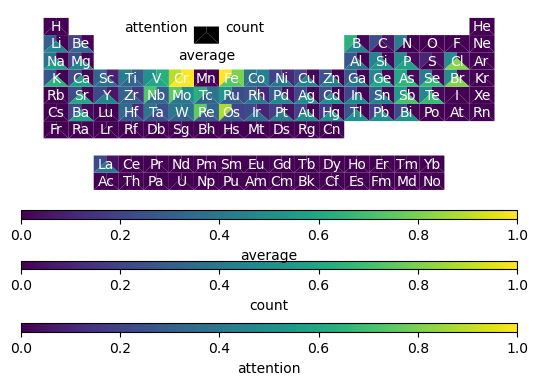

In [84]:
def eneg(elt):
    """Electronegativity"""
    return elt['electronegativity']

def mass(elt):
    """Mass"""
    return elt['mass']

def attention(elt):
    """attention"""
    return elt['attention']

def count(elt):
    """count"""
    return elt['count']

def average(elt):
    """average"""
    return elt['average']

epd = ElementDataPlotter(data)
epd.ptable([attention,count,average])
plt.savefig("result/table.png",dpi=2400)
plt.show()

In [34]:
count_mag[61,1]=0

In [19]:
numlist

array([2, 1, 1])

In [39]:
average_mag[:,1]

array([0.        , 0.        , 0.24983817, 0.18500843, 0.23372008,
       0.01233184, 0.        , 0.        , 0.        , 0.        ,
       0.3019737 , 0.24665388, 0.20245962, 0.28526761, 0.31602487,
       0.        , 0.44660478, 0.        , 0.34718685, 0.30640128,
       0.20181489, 0.17985185, 0.32277318, 0.54254375, 0.5784118 ,
       0.39758509, 0.19897955, 0.21858435, 0.24427653, 0.2297595 ,
       0.22663141, 0.32299618, 0.35422658, 0.35828993, 0.44099134,
       0.        , 0.        , 0.32252558, 0.24430736, 0.16709895,
       0.17727796, 0.2116659 , 0.17174225, 0.16588295, 0.21060281,
       0.24873253, 0.2600824 , 0.266214  , 0.25252151, 0.23444291,
       0.38498649, 0.36458089, 0.        , 0.        , 0.        ,
       0.31234713, 0.21327642, 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.14047926, 0.12970495, 0.16527013, 0.14109

In [19]:
count_mag[19:30],average_mag[19:30]

(array([[17488.   ,   930.228],
        [17560.   ,  4566.016],
        [20149.   , 16698.605],
        [22035.   , 38959.967],
        [26262.   , 74152.385],
        [28083.   , 86402.927],
        [28064.   , 63626.66 ],
        [30454.   , 37567.764],
        [15526.   ,  5097.013],
        [14870.   ,   765.585],
        [15491.   ,   303.622]]),
 array([[16850.        , 10607.37981798],
        [16734.        ,  8784.20712736],
        [19193.        ,  9653.47742019],
        [21057.        , 13600.50546635],
        [24847.        , 21509.06786696],
        [26516.        , 23904.93275692],
        [26302.        , 18955.90132425],
        [28616.        , 14940.30952572],
        [15045.        ,  8149.89398914],
        [14350.        ,  8142.09443576],
        [14941.        ,  8260.52491476]]))

In [127]:
df.loc[i,'spinD']

'[-0.003, 0.87, 0.279]'